In [1]:
from importlib import reload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gptomics import plot, model, composition as comp

In [2]:
df = pd.read_csv("../data/220508_gpt-j-compositions.csv", index_col=0)

In [3]:
df.head()

,src_type,src_layer,src_index,dst_type,dst_layer,dst_index,term_type,term_value
0,layernorm_bias,0,0,att_head,0,0,Q,0.010643
1,layernorm_bias,0,0,att_head,0,1,Q,0.017541
2,layernorm_bias,0,0,att_head,0,2,Q,0.017403
3,layernorm_bias,0,0,att_head,0,3,Q,0.023598
4,layernorm_bias,0,0,att_head,0,4,Q,0.014652


# Spot checking values

In [4]:
gptj = model.model_by_name("GPTJ")

### Max value

In [5]:
df[df.term_value == df.term_value.max()]

,src_type,src_layer,src_index,dst_type,dst_layer,dst_index,term_type,term_value
22097,layernorm_bias,1,0,att_head,1,1,K,0.099647


#### Using the same SVD method

In [6]:
bias = gptj.layernorm_biases(1)

In [7]:
qk = gptj.QK(1, 1)

In [8]:
product = qk @ bias

In [9]:
(np.linalg.norm(product.S)
 / (np.linalg.norm(qk.S) * np.linalg.norm(bias.S)))

0.099647336

#### Using the full matrices

In [10]:
bias = gptj.layernorm_biases(1, factored=False)

In [11]:
qk = gptj.QK(1, 1, factored=False)

In [12]:
product = qk @ bias
(comp.frobnorm(product)
 / (comp.frobnorm(qk) * comp.frobnorm(bias)))

0.09964855

Cool

### Min value

In [13]:
df[df.term_value == df.term_value.min()]

,src_type,src_layer,src_index,dst_type,dst_layer,dst_index,term_type,term_value
42,layernorm_bias,0,0,att_head,0,10,V,0.005694


#### Using the same SVD method

In [14]:
bias = gptj.layernorm_biases(0)

In [15]:
ov = gptj.OV(0, 10)

In [16]:
(np.linalg.norm((ov @ bias).S)
 / (np.linalg.norm(ov.S) * np.linalg.norm(bias.S)))

0.005694169

#### Using the full matrices

In [17]:
bias = gptj.layernorm_biases(0, factored=False)

In [18]:
ov = gptj.OV(0, 10, factored=False)

In [19]:
product = ov @ bias
(comp.frobnorm(product)
 / (comp.frobnorm(ov) * comp.frobnorm(bias)))

0.005694231

# Plot basic distributions

In [20]:
fs=fontsize=20

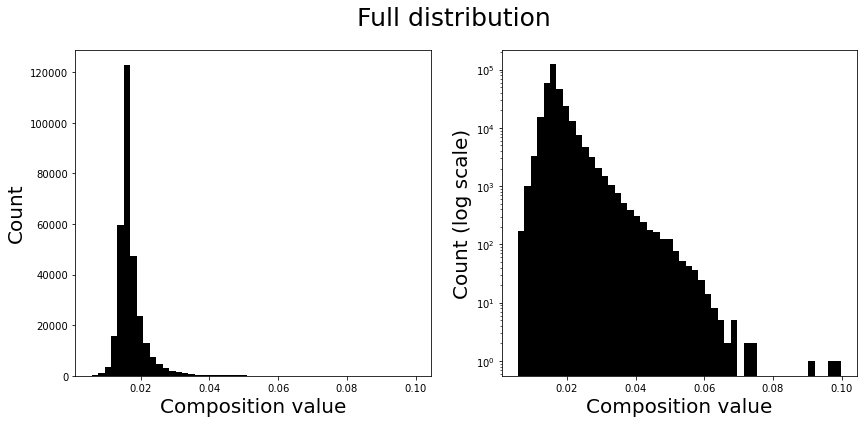

In [21]:
fig = plt.figure(figsize=(14, 6))
fig.suptitle("Full distribution", fontsize=fs+5)

plt.subplot(1, 2, 1)
plt.hist(df.term_value, bins=50, color='k')

plt.xlabel("Composition value", fontsize=fs)
plt.ylabel("Count", fontsize=fs)

plt.subplot(1, 2, 2)
plt.hist(df.term_value, bins=50, color='k')

plt.xlabel("Composition value", fontsize=fs)
plt.ylabel("Count (log scale)", fontsize=fs)
plt.yscale("log")
plt.show()

In [22]:
def logspace_bins(values, bins=10):
    minval, maxval = np.log(np.min(values)), np.log(np.max(values))
    
    return np.exp(np.linspace(minval, maxval, bins))

In [23]:
attdf = df[(df.src_type == "att_head") &
           (df.dst_type == "att_head")]

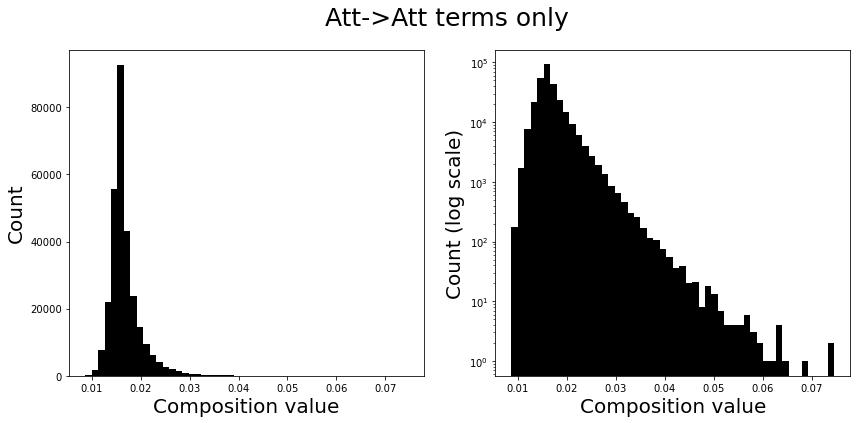

In [24]:
fig = plt.figure(figsize=(14, 6))
fig.suptitle("Att->Att terms only", fontsize=fs+5)

plt.subplot(1, 2, 1)
plt.hist(attdf.term_value, bins=50, color='k')

plt.xlabel("Composition value", fontsize=fs)
plt.ylabel("Count", fontsize=fs)

plt.subplot(1, 2, 2)
plt.hist(attdf.term_value, bins=50, color='k')

plt.xlabel("Composition value", fontsize=fs)
plt.ylabel("Count (log scale)", fontsize=fs)
plt.yscale("log")
plt.show()

# Analyze values by types

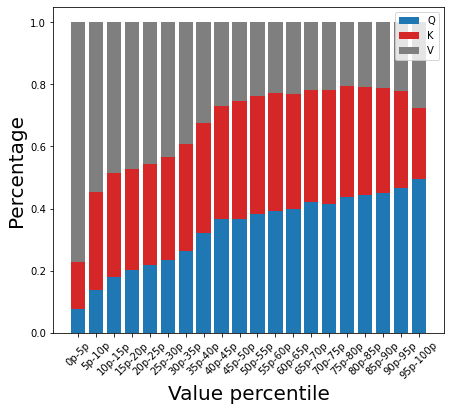

In [25]:
plt.figure(figsize=(7, 6))

plot.percentiles_by_type(
    attdf,
    "term_type",
    types=["Q", "K", "V"],
    colors=[plot.COLORS[0], plot.COLORS[3], plot.COLORS[7]]
)
plt.show()

In [26]:
attdf["layergroup"] = attdf["dst_layer"] // 4

/tmp/ipykernel_10544/4083385093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attdf["layergroup"] = attdf["dst_layer"] // 4


In [27]:
colors = plot.COLORS * 3

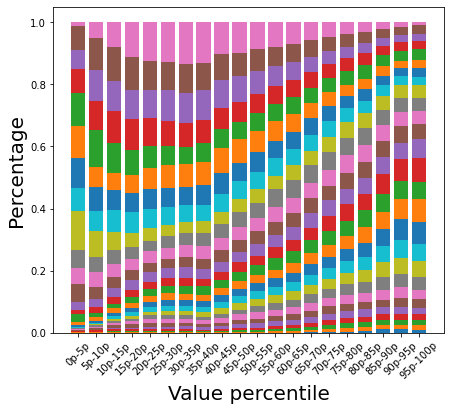

In [28]:
plt.figure(figsize=(7, 6))

plot.percentiles_by_type(
    attdf,
    "dst_layer",
    colors=colors,
    legend=False,
)
plt.show()

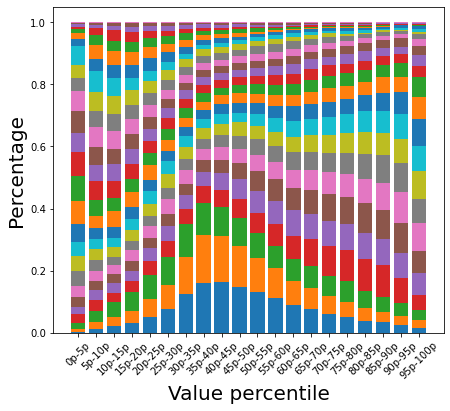

In [29]:
plt.figure(figsize=(7, 6))

plot.percentiles_by_type(
    attdf,
    "src_layer",
    colors=colors,
    legend=False,
)
plt.show()

In [30]:
df.groupby("src_type").count()["term_value"] / df.shape[0]

src_type
att_head          0.937093
layernorm_bias    0.062907
Name: term_value, dtype: float64

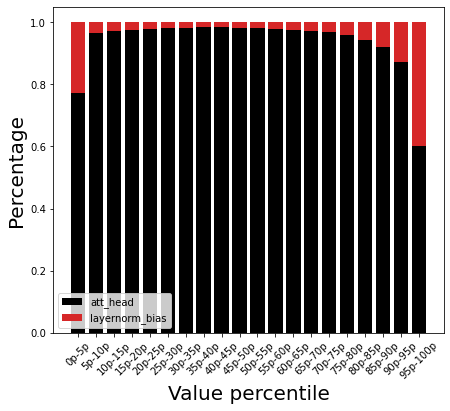

In [31]:
plt.figure(figsize=(7, 6))

plot.percentiles_by_type(
    df,
    "src_type",
    colors=['k', colors[3]],
)
plt.show()

# Looking into layer norm terms

In [32]:
df["overall_5p_grp"] = plot.compute_percentile_bins(df, nbins=20)

In [33]:
percs = np.percentile(df.term_value, np.arange(21) * 5)

In [34]:
percs[-2]

0.02451042175

In [35]:
lndf = df[df.src_type == "layernorm_bias"]

In [36]:
lndf[lndf.overall_5p_grp == 20]

,src_type,src_layer,src_index,dst_type,dst_layer,dst_index,term_type,term_value,overall_5p_grp
8,layernorm_bias,0,0,att_head,0,8,Q,0.032444,20
11,layernorm_bias,0,0,att_head,0,11,Q,0.035814,20
17,layernorm_bias,0,0,att_head,0,1,K,0.028804,20
18,layernorm_bias,0,0,att_head,0,2,K,0.031719,20
19,layernorm_bias,0,0,att_head,0,3,K,0.031364,20
...,...,...,...,...,...,...,...,...,...
309774,layernorm_bias,27,0,att_head,27,14,K,0.031322,20
309775,layernorm_bias,27,0,att_head,27,15,K,0.027735,20
309782,layernorm_bias,27,0,att_head,27,6,V,0.024962,20
309789,layernorm_bias,27,0,att_head,27,13,V,0.045260,20


Prob that a term with `src_layer == dst_layer` is in the top group

In [37]:
np.mean(lndf.overall_5p_grp[lndf.src_layer == lndf.dst_layer] == 20)

0.45982142857142855

Prob that a term with `src_layer != dst_layer` is in the top group

In [38]:
np.mean(lndf.overall_5p_grp[lndf.src_layer != lndf.dst_layer] == 20)

0.3055004409171076

Prob that a term with in the top group has `src_layer == dst_layer`

In [39]:
topgroup = lndf[lndf.overall_5p_grp == 20]
diffs = topgroup.dst_layer - topgroup.src_layer

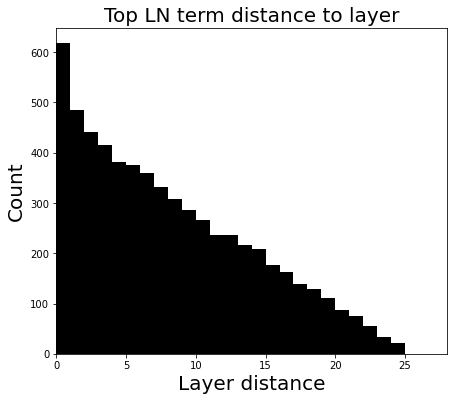

In [40]:
plt.figure(figsize=(7, 6))

plt.hist(diffs, bins=np.arange(28), color='k')

plt.xlabel("Layer distance", fontsize=fs)
plt.ylabel("Count", fontsize=fs)
plt.xlim(0, 28)
plt.title("Top LN term distance to layer", fontsize=fs)

plt.show()

### Same plot for attention heads

In [41]:
attdf = df[df.src_type == "att_head"]

In [42]:
percs[-2]

0.02451042175

In [43]:
reload(plot)

<module 'gptomics.plot' from '/home/nt/Work/research/gpt-omics/gptomics/plot.py'>

<AxesSubplot:xlabel='Layer distance', ylabel='Count'>

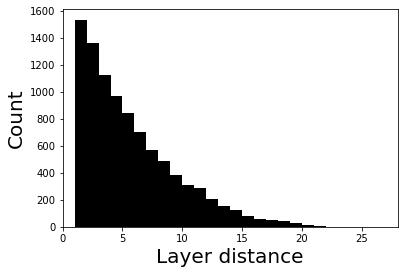

In [44]:
plot.plot_grp_layerdist_hist(attdf)

<AxesSubplot:xlabel='Layer distance', ylabel='Count'>

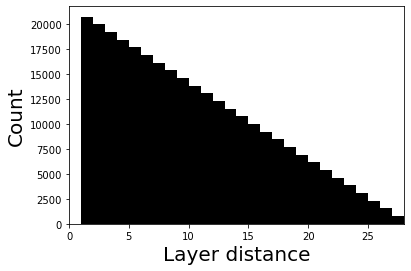

In [45]:
plot.plot_layerdists(attdf)

<AxesSubplot:xlabel='Layer distance', ylabel='Count'>

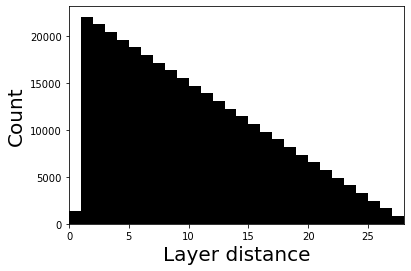

In [46]:
plot.plot_layerdists(df)

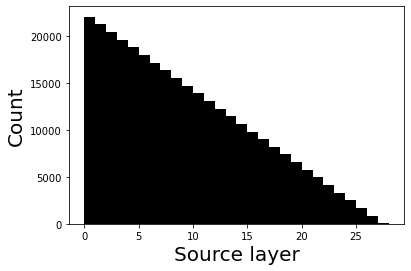

In [47]:
plt.hist(df.src_layer, bins=np.arange(29), color='k')
plt.xlabel("Source layer", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.show()

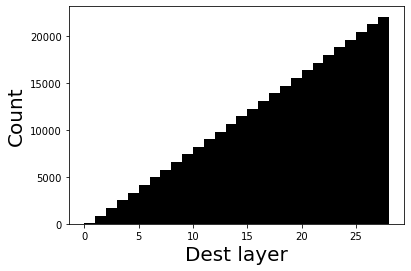

In [48]:
plt.hist(df.dst_layer, bins=np.arange(29), color='k')
plt.xlabel("Dest layer", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.show()

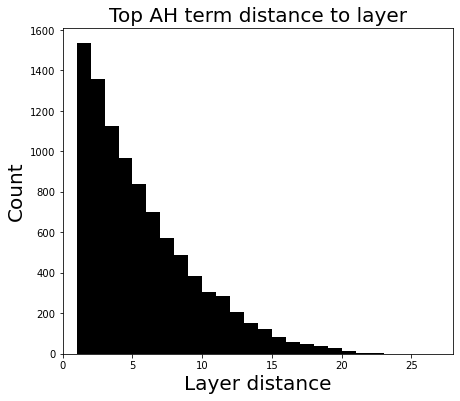

In [49]:
topgroup = attdf[attdf.overall_5p_grp == 20]
diffs = topgroup.dst_layer - topgroup.src_layer

plt.figure(figsize=(7, 6))

plt.hist(diffs, bins=np.arange(28), color='k')

plt.xlabel("Layer distance", fontsize=fs)
plt.ylabel("Count", fontsize=fs)
plt.xlim(0, 28)
plt.title("Top AH term distance to layer", fontsize=fs)

plt.show()